### Create Hippocampus Mask

This notebook create hippocampus mask so that searchlight can be run within hippocampus
Considering that an elongated shape, running searchlight can introduces noises from surrounding structures to see any signature of pattern separation

In [1]:
# load packages
import os  
import pandas as pd
import glob
import nibabel as nib
import numpy as np
import json

from nilearn import image, plotting, masking
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker

from bids import BIDSLayout, BIDSValidator

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
# set paths for directories
home_path = os.path.expanduser('~')
project_path = os.path.join(home_path,'Desktop','artists_2021')
data_path = os.path.join(project_path,'data')
note_path = os.path.join(project_path,'runs','projects','rsa_learning_c')
mask_path = os.path.join(note_path,'masks')

scratch_folder = os.path.join(project_path,'scratch')
if not os.path.exists(os.path.join(scratch_folder,'rsa_learning_c')):
    os.makedirs(os.path.join(scratch_folder,'rsa_learning_c'))

deposit_path = os.path.join(scratch_folder,'rsa_learning_c')

# load atals

In [12]:
# manipulating atlas
base_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'
atlas_path = os.path.join(base_dir,'analysis','BN_atlas')

#atlas_path = os.path.join(project_path,'atlas','bn_atlas')
if not os.path.exists(atlas_path):
    atlas_path = os.path.join(project_path,'atlas','bn_atlas') 
    
atlas_filename = os.path.join(atlas_path,'BN_Atlas_246_2mm.nii.gz')
label_filename = os.path.join(atlas_path,'BN_Atlas_246_LUT.txt')

# read look-up-table and images
master_label = pd.read_csv(label_filename, sep=' ', names = ['index','region','dx','dy','dz','dummy']).reset_index(drop = True)
master_atlas = image.load_img(atlas_filename)

In [13]:
master_label

,index,region,dx,dy,dz,dummy
0,0,Unknown,25,5,25,0
1,1,A8m_L,0,255,0,0
2,2,A8m_R,0,0,255,0
3,3,A8dl_L,255,0,0,0
4,4,A8dl_R,0,246,255,0
...,...,...,...,...,...,...
242,242,Otha_R,237,70,255,0
243,243,cTtha_L,167,62,202,0
244,244,cTtha_R,246,229,158,0
245,245,lPFtha_L,88,237,123,0


In [3]:
mask_dir = os.path.join(base_dir, 'analysis', 'Masks')
mask_file = os.path.join(mask_dir, 'MNI152NLin2009cAsym_mask.nii.gz')
#mask_file = os.path.join(mask_path,'brain_mask.nii.gz')
mask_image = image.load_img(mask_file) # this file for affine information
master_atlas = image.resample_to_img(master_atlas,mask_image) # transform affine for master atlas

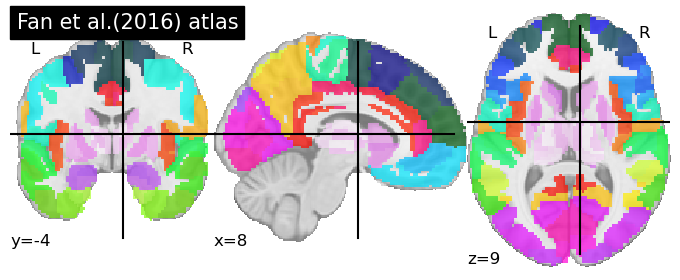

In [4]:
plotting.plot_roi(master_atlas, title='Fan et al.(2016) atlas', cut_coords=(8, -4, 9))

# Get index of ROIs - HPC

In [14]:
# get index of hippocampus (cHipp_R, rHipp_R, cHipp_L, rHipp_L)

set_label = master_label[(master_label['region'] == 'cHipp_R') | 
                         (master_label['region'] == 'rHipp_R') |
                         (master_label['region'] == 'cHipp_L') |
                         (master_label['region'] == 'rHipp_L')].index 
set_label

Int64Index([215, 216, 217, 218], dtype='int64')

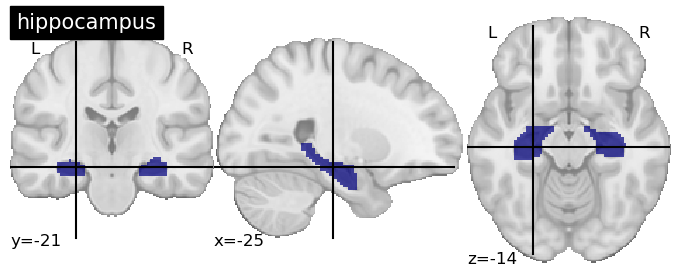

In [15]:
# ROI mask from atlas
brain_roi = image.math_img('img*0', img = master_atlas)
for index in set_label:
    brain_roi = image.math_img('np.logical_or(img0, img1 == %s)' %(index), img0 = brain_roi, img1 = master_atlas) # ROI mask from atlas

plotting.plot_roi(brain_roi,title='hippocampus')

In [17]:
# save brain mask
output_name = os.path.join(base_dir,'analysis','Masks', 'BN_2mm_hippocampus_mask_.nii.gz' )
nib.save(brain_roi, output_name)

#

In [23]:
set_label = master_label[(master_label['region'] == 'A35/36c_R') | 
                         (master_label['region'] == 'A35/36r_R') |
                         (master_label['region'] == 'A35/36c_L') |
                         (master_label['region'] == 'A35/36r_L') |
                         (master_label['region'] == 'TL_L') |
                         (master_label['region'] == 'TL_R') |
                         (master_label['region'] == 'A28/34_L') |
                         (master_label['region'] == 'A28/34_R') |
                         (master_label['region'] == 'TH_L') |
                         (master_label['region'] == 'TH_R') |
                         (master_label['region'] == 'TI_L') |
                         (master_label['region'] == 'TI_R')].index 
set_label

Int64Index([109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120], dtype='int64')

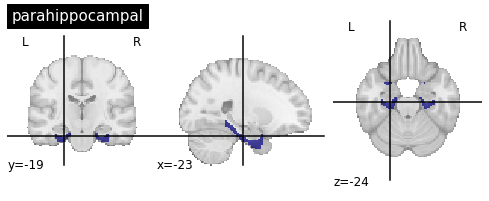

In [25]:
brain_roi = image.math_img('img*0', img = master_atlas)
for index in set_label:
    brain_roi = image.math_img('np.logical_or(img0, img1 == %s)' %(index), img0 = brain_roi, img1 = master_atlas) # ROI mask from atlas

plotting.plot_roi(brain_roi,title='parahippocampal')

In [26]:
# save brain mask
nib.save(brain_roi, os.path.join(mask_path,'parahippocampal.nii.gz'))